In [1]:
IntervalDim = 100
VelocityDim = 32
VelocityOffset = IntervalDim

NoteOnDim = NoteOffDim = 128
NoteOnOffset = IntervalDim + VelocityDim
NoteOffOffset = IntervalDim + VelocityDim + NoteOnDim

CCDim = 2
CCOffset = IntervalDim + VelocityDim + NoteOnDim + NoteOffDim
EventDim = IntervalDim + VelocityDim + NoteOnDim + NoteOffDim + CCDim # 390

Time = 256
EmbeddingDim = 512
HeadDim = 16
Heads = 16
ContextDim = HeadDim * Heads # 512
Layers = 8

In [2]:
def default_hparams():
    return {
        "EventDim":EventDim,
        "ContextDim":ContextDim,
        "EmbeddingDim":EmbeddingDim,
        "Heads":Heads,
        "Layers":Layers,
        "Time":Time
    }

hparams = default_hparams()
print(hparams['Heads'])

16


In [3]:
from Transformer import TransformerGenerator,TransformerDiscriminator
generator = TransformerGenerator(hparams,input_shape = (256,1))
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
None_stack-1_dilated-1_causal_c (None, 256, 512)     1536        input_1[0][0]                    
__________________________________________________________________________________________________
normalize_diagonal (NormalizeDi (None, 256, 512)     1024        None_stack-1_dilated-1_causal_con
__________________________________________________________________________________________________
my_convld (MyConvld)            (1, 256, 1536)       787968      normalize_diagonal[0][0]         
______________________________________________________________________________________________

In [4]:
discriminator = TransformerDiscriminator(hparams,input_shape = (256,1))
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
None_stack-1_dilated-1_causal_c (None, 256, 512)     1536        input_2[0][0]                    
__________________________________________________________________________________________________
normalize_diagonal_17 (Normaliz (None, 256, 512)     1024        None_stack-1_dilated-1_causal_con
__________________________________________________________________________________________________
my_convld_32 (MyConvld)         (1, 256, 1536)       787968      normalize_diagonal_17[0][0]      
____________________________________________________________________________________________

In [5]:
import numpy as np
train_data = np.load("preprocess_data.npy")

In [6]:
train_data = train_data[:1000]

In [7]:
# Rescale 0 to 1
train_data = train_data / 128

In [8]:
train_data = train_data.reshape(-1,256,1)
train_data.shape

(1000, 256, 1)

In [9]:
Batch = 1

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
@tf.function
def train_step(music):
    noise = tf.random.normal([Batch,Time,1])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_music = generator(noise, training=True)
        real_output = discriminator(music, training=True)
        fake_output = discriminator(generated_music, training=True)
   
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [14]:
import time
from IPython.display import  clear_output
gloss_list=[]
dloss_list=[]
def train(dataset, epochs):
    total_step = 0
    G_loss = 0
    D_loss = 0
    for epoch in range(epochs):
        start = time.time()
        for i,image_batch in enumerate(dataset):
            gen_loss,disc_loss = train_step(image_batch)
            print(f"Step：{i} | G_loss：{gen_loss} D_loss：{disc_loss}|")
            G_loss += gen_loss
            D_loss += disc_loss
            total_step += 1
            if total_step%100 == 0:
                clear_output(wait=True)
                print(f'G_AVE_Loss：{G_loss/100}')
                print(f'D_AVE_loss：{D_loss/100}')
                gloss_list.append(G_loss/100)
                dloss_list.append(D_loss/100)
                G_loss = 0
                D_loss = 0
        print (f'Time for epoch {epoch + 1} is {time.time()-start} sec\n')

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(Batch,drop_remainder=True)

In [16]:
train(train_dataset,1)

G_AVE_Loss：1.3062931299209595
D_AVE_loss：0.9548113346099854
Time for epoch 1 is 1741.4747514724731 sec



In [17]:
np.save('0612_MTgan_gloss.npy', np.array(gloss_list))
np.save('0612_MTgan_dis_dloss.npy',np.array(dloss_list))

In [18]:
import random
from mido import MidiFile, MidiTrack, Message
noise = tf.random.normal([Batch,Time,1])
predict = generator.predict(noise)
predict = predict*128

In [19]:
predict

array([[[34.431458],
        [56.584774],
        [71.2927  ],
        [88.85265 ],
        [87.824455],
        [69.908585],
        [46.85875 ],
        [91.25684 ],
        [79.24675 ],
        [74.39792 ],
        [80.56776 ],
        [64.65804 ],
        [82.41598 ],
        [85.012924],
        [84.33573 ],
        [90.6291  ],
        [63.885445],
        [48.578236],
        [84.428215],
        [51.74227 ],
        [49.74444 ],
        [80.39149 ],
        [76.504974],
        [44.015034],
        [43.240673],
        [92.034485],
        [93.529366],
        [60.795067],
        [87.903244],
        [90.0975  ],
        [66.79485 ],
        [90.413124],
        [71.8819  ],
        [73.353745],
        [60.502274],
        [72.483315],
        [79.362495],
        [72.17658 ],
        [77.51386 ],
        [92.833015],
        [86.71224 ],
        [78.12935 ],
        [59.601635],
        [79.175545],
        [91.90153 ],
        [79.634186],
        [62.58506 ],
        [82.7

In [20]:
midler = MidiFile()
track = MidiTrack()
midler.tracks.append(track)
track.append(Message('program_change', program=2, time=0))

for x in range(256):
    on_interval = random.randint(50,127)
    off_interval = random.randint(0,127)
    change_interval = random.randint(0,127)
    change_value = random.randint(0,127)
    isControl = random.randint(0,1)
    track.append(Message('note_on',channel =1, note=int(predict[0][x][0]), velocity=64, time = on_interval)) 
    if isControl:
            track.append(Message('control_change',channel =1, control=64, value=change_value, time = change_interval)) 
    track.append(Message('note_off',channel =1 ,note=int(predict[0][x][0]), velocity=64, time = off_interval))
midler.save('MT_song.mid')

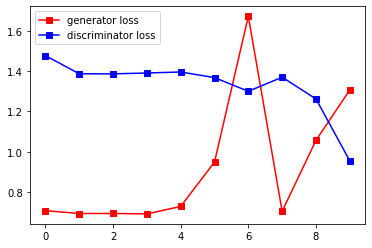

In [21]:
import matplotlib.pyplot as plt
g = np.load('0612_MTgan_gloss.npy')
month = [i for i in range(len(g))]
plt.plot(g,'s-',color = 'r', label="generator loss")
d=np.load('0612_MTgan_dis_dloss.npy')
plt.plot(d,'s-',color = 'b', label="discriminator loss")
plt.legend(loc = "best", fontsize=10)
plt.show()